# Predicción de Riesgo de Evento Cardíaco con Señales de ECG Usando la Base de Datos PTB Diagnostic ECG.

El desafío seleccionado es predecir el riesgo de un evento cardíaco utilizando señales de ECG. Este desafío se centra en el análisis de datos electrocardiográficos (ECG) de la base de datos PTB Diagnostic ECG, donde se desarrollará un modelo predictivo para identificar el riesgo de eventos cardíacos en pacientes con historial de enfermedades cardíacas.

*El procesamiento de los datos es lento debido a la cantidad de datos a utilizar (1,7gb con 549 registros de 290 sujetos), por lo que se sugiere realizar este procesamiento de forma local. Mas información en https://research.google.com/colaboratory/local-runtimes.html*





Los datos fueron extraidos directamente de la pagina Physionet.org y subidas a una carpeta de google drive sin alterar su contenido.

Enlace original: https://physionet.org/content/ptbdb/1.0.0/

## Obtención de Datos



Aqui se realiza la importación de modulo de Google Collab que permite cargar archivos de Google Drive


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')




Selección de ruta de la base de datos



In [2]:
# Ruta a la carpeta compartida en My Drive
# Enlace de la base de datos: https://drive.google.com/drive/folders/1POBJnXe2nfFJK5jtWNa7onvDlyP9ArVJ?usp=sharing
# Se debe agregar a "Mi unidad" para poder utilizar los datos
# Para lo anterior, ubicarse en la carpeta "Compartido conmigo" y arrastrarla hacia el menu de la izquierda y dejarla en la carpeta "Mi unidad". Se creará un acceso directo.
#  recargar la pagina de Google Collab para ver la nueva carpeta agregada


# folder_path = '/content/drive/MyDrive/ptb-diagnostic-ecg-database-1.0.0'      # Ruta en Google Drive
folder_path = './ptb-diagnostic-ecg-database-1.0.0'                             # Ruta local




Aqui se utiliza el archivo RECORDS que contiene todas las referencias de los nombres de los pacientes como tambien de sus archivos asociados

In [3]:
ruta_records = folder_path + '/RECORDS'

# Leer el archivo 'records' para obtener la lista de archivos
with open(ruta_records, 'r') as f:
    registros = f.read().splitlines()

# Ver los registros cargados
print(registros)

['patient001/s0010_re', 'patient001/s0014lre', 'patient001/s0016lre', 'patient002/s0015lre', 'patient003/s0017lre', 'patient004/s0020are', 'patient004/s0020bre', 'patient005/s0021are', 'patient005/s0021bre', 'patient005/s0025lre', 'patient005/s0031lre', 'patient005/s0101lre', 'patient006/s0022lre', 'patient006/s0027lre', 'patient006/s0064lre', 'patient007/s0026lre', 'patient007/s0029lre', 'patient007/s0038lre', 'patient007/s0078lre', 'patient008/s0028lre', 'patient008/s0037lre', 'patient008/s0068lre', 'patient009/s0035_re', 'patient010/s0036lre', 'patient010/s0042lre', 'patient010/s0061lre', 'patient011/s0039lre', 'patient011/s0044lre', 'patient011/s0049lre', 'patient011/s0067lre', 'patient012/s0043lre', 'patient012/s0050lre', 'patient013/s0045lre', 'patient013/s0051lre', 'patient013/s0072lre', 'patient014/s0046lre', 'patient014/s0056lre', 'patient014/s0071lre', 'patient015/s0047lre', 'patient015/s0057lre', 'patient015/s0152lre', 'patient016/s0052lre', 'patient016/s0060lre', 'patient01

Instalación de librerías

In [4]:
%pip install wfdb
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Carga de datos en una lista

In [5]:

import wfdb
import os

# Ruta base donde están las carpetas de los pacientes
ruta_base_datos = folder_path

# Lista para almacenar todos los registros cargados
todos_los_registros = []

# Iterar sobre los registros del archivo 'records'
for registro in registros:
    try:
        # Construir la ruta completa para el archivo
        record_path = os.path.join(ruta_base_datos, registro)

        # Cargar el archivo
        record = wfdb.rdrecord(record_path)

        # Agregar el registro cargado a la lista
        todos_los_registros.append(record)

        #print(f"Cargado: {record_path}")

    except Exception as e:
        print(f"Error cargando {record_path}: {e}")

print(f"Total de registros cargados: {len(todos_los_registros)}")

Total de registros cargados: 549


## Identificación de Pacientes STEMI y HC

La base de datos PTB Diagnostic ECG contiene un atributo llamado "comments" el cual contiene información relevante sobre el paciente, en este caso se busca identificar a los pacientes que han sufrido un infarto agudo de miocardio (STEMI) y los pacientes con control sanos (HC).

### Pacientes con Infarto Agudo de Miocardio con Elevación del Segmento ST (STEMI)

Aqui se listan los valores unicos del atributo 'Acute infarction (localization)' al interior del atributo "comments" y se cuenta su frecuencia.
En este caso el atributo 'Acute infarction (localization)' contiene la información de la localización del evento cardiaco, por lo tanto se realiza una busqueda en ese campo.



In [6]:
locations_frecuencia = {}

for record in todos_los_registros:
    location = record.comments[5].split(':')[1].strip()
    if location in locations_frecuencia:
        locations_frecuencia[location]['frec'] += 1
    else:
        locations_frecuencia[location] = {'nombre': location, 'frec': 1}

print('Frecuencia de cada valor único del atributo Acute infarction (localization):')
for location, data in locations_frecuencia.items():
    print(f"{data['nombre']}")

Frecuencia de cada valor único del atributo Acute infarction (localization):
infero-latera
anterior
infero-postero-lateral
antero-septal
inferior
infero-lateral
infero-poster-lateral
antero-lateral
lateral
postero-lateral
posterior
no
infero-posterior
n/a
antero-septo-lateral
unknown


Aqui se muestra un histograma de frecuencias de cada localización encontrada en el apartado 'Acute infarction (localization)' en el atributo 'comments' de la base de datos PTB Diagnostic ECG.

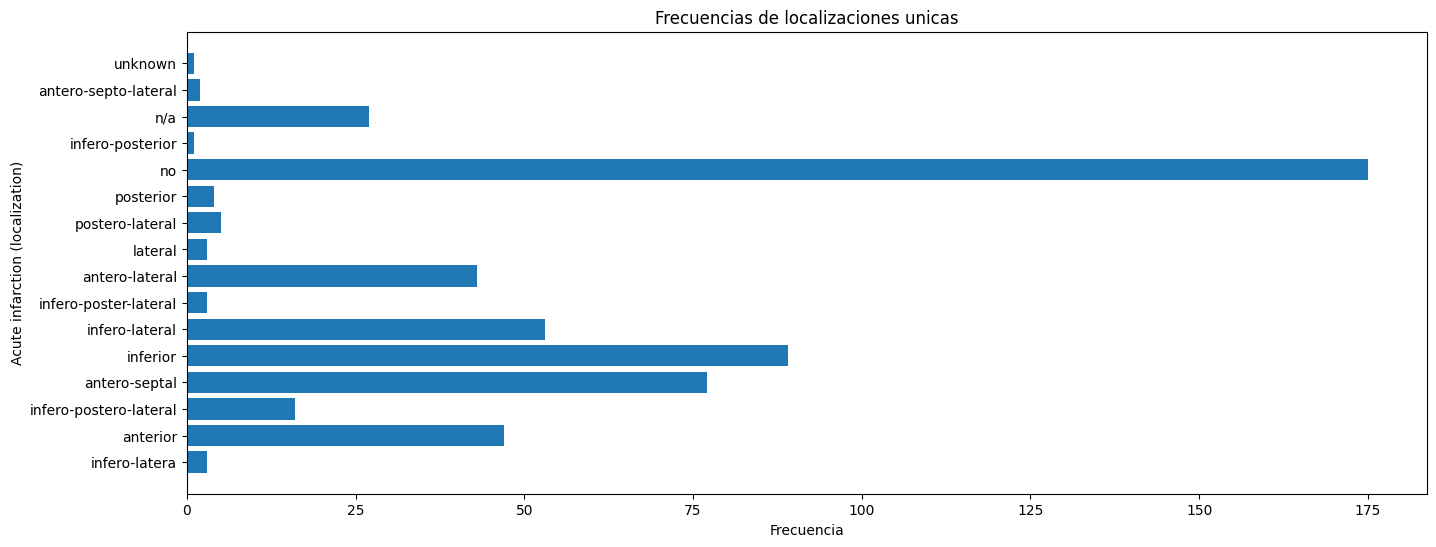

In [7]:
# Plot de frecuencias de localizaciones unicas
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
frequencies = [data['frec'] for data in locations_frecuencia.values()]

plt.title('Frecuencias de localizaciones unicas')
plt.barh(list(locations_frecuencia.keys()), frequencies)
plt.ylabel('Acute infarction (localization)')
plt.xlabel('Frecuencia')
plt.show()

 Filtrado de registros que tengan localización descrita en su atributo 'comments'

Aqui se hace un filtrado de los registros que contengan información relacionada a STEMI en su atribubo 'comments'. Para esto, se quitan los registros que contengan 'no','n/a' y 'unknown' en el apartado de 'Acute infarction (localization)'.

In [8]:
stemi_records = []
stemi_avoid_locations = ['no', 'n/a', 'unknown']

for record in todos_los_registros:
    reason = record.comments[4].split(':')[1].strip()
    localization1 = record.comments[5].split(':')[1].strip()

    # Agregar record a stemi_records si reason no esta en stemi_avoid_locations
    if reason == 'Myocardial infarction':
        if localization1 not in stemi_avoid_locations:
            stemi_records.append(record)

print("Total de stemi_records: ", len(stemi_records))

Total de stemi_records:  346


Aqui se hace nuevamente un recuento de los valores unicos filtrados en el atributo 'Acute infarction (localization)' en el atributo 'comments' de la base de datos PTB Diagnostic ECG .

In [9]:
locations_frecuencia_stemi = {}
for record in stemi_records:
    location = record.comments[5].split(':')[1].strip()
    if location in locations_frecuencia_stemi:
        locations_frecuencia_stemi[location]['frec'] += 1
    else:
        locations_frecuencia_stemi[location] = {'nombre': location, 'frec': 1}

Histograma de frecuencias de localizaciones STEMI

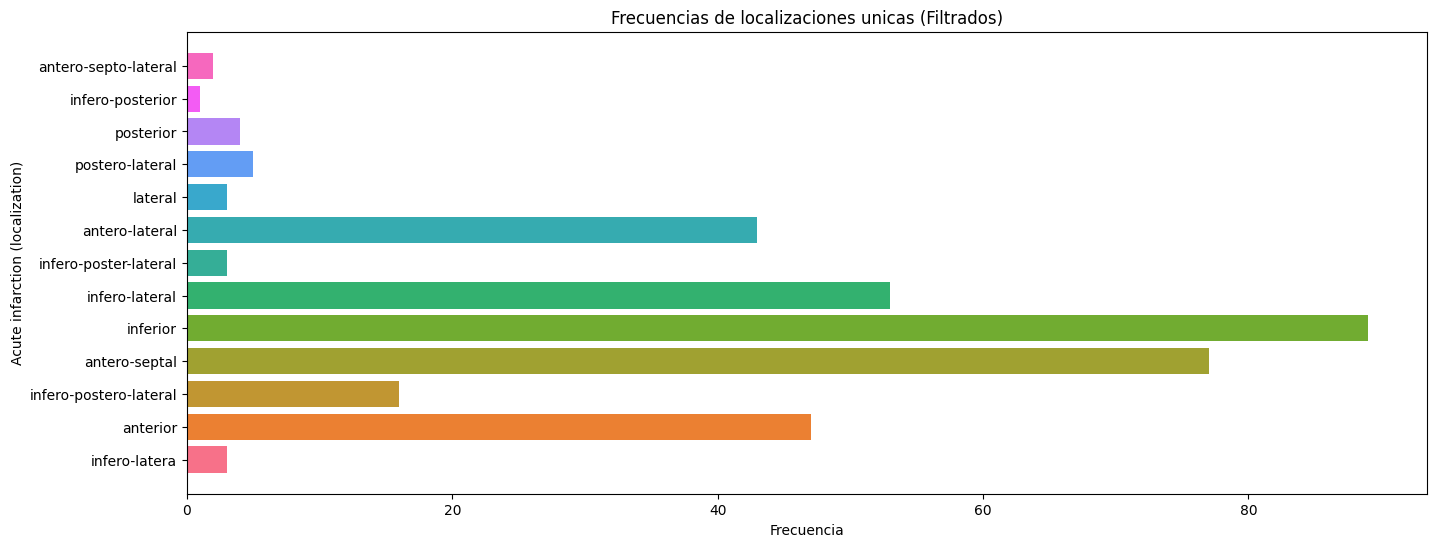

In [10]:

import seaborn as sns

# Plot de frecuencias de localizaciones unicas
import matplotlib.pyplot as plt

# Definir una paleta de colores
palette = sns.color_palette("husl", len(locations_frecuencia_stemi))

plt.figure(figsize=(16, 6))
stemi_frequencies = [data['frec'] for data in locations_frecuencia_stemi.values()]

plt.title('Frecuencias de localizaciones unicas (Filtrados)')
plt.barh(list(locations_frecuencia_stemi.keys()), stemi_frequencies, color=palette)
plt.ylabel('Acute infarction (localization)')
plt.xlabel('Frecuencia')
plt.show()

### Pacientes Control Sanos (HC)

Aqui se hace una selección de los registros de contol sanos. Este proceso es mas sencillo que el anterior ya que se busca directamente en el atributo 'comments' la palabra 'healthy control en el apartado 'Reason for admission'.

En este caso 'Reason for admission' está localizado en el lugar 5 del atributo 'comments' de la base de datos PTB Diagnostic ECG.

In [11]:
HC_records = []

for record in todos_los_registros:
    reason = record.comments[4].split(':')[1].strip() # apartado de 'Reason for admission'

    # Agregar record a HC_records si reason es 'Healthy control'
    if reason == 'Healthy control':
        HC_records.append(record)

print("Total de la HC_records: ", len(HC_records))

Total de la HC_records:  80


### Comparación de registros STEMI y HC

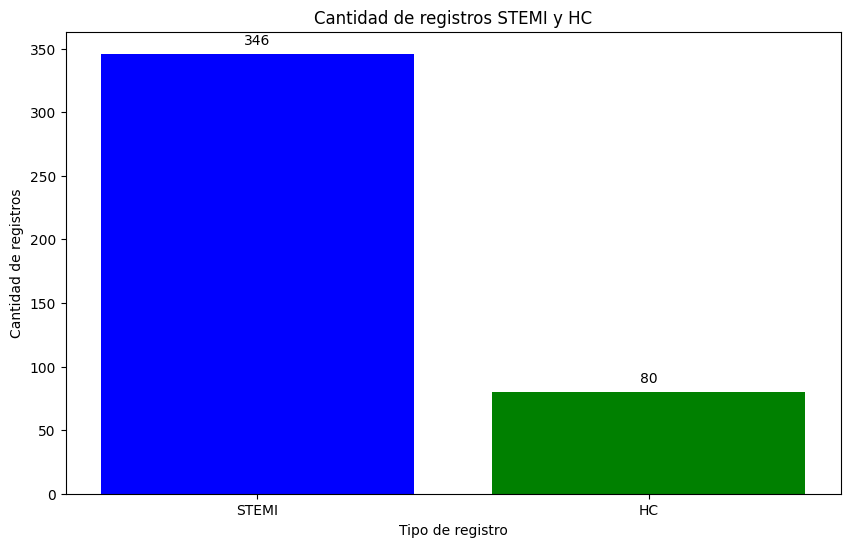

In [12]:
# Histograma de cantidad de registros STEMI de la viable stemi_records y HC_records
plt.figure(figsize=(10, 6))
bars = plt.bar(['STEMI', 'HC'], [len(stemi_records), len(HC_records)], color=['blue', 'green'])
plt.title('Cantidad de registros STEMI y HC')
plt.xlabel('Tipo de registro')
plt.ylabel('Cantidad de registros')

# Agregar números encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.show()


### Liberación de Memoria

Luego de obtener estos 2 sets de registros, se procede a liberar la memoria de los registros que no se utilizarán en el análisis.

In [13]:
todos_los_registros.clear()

## Preprocesamiento de Señales ECG

Para el procesamiento de las señales ECG se realizaran las siguientes tareas:
- **Eliminación de canales de posicion de electrodos** identificando los nombres Vx, Vy y Vz.
- **Filtrado de ruido** mediante un filtro pasa banda Butterworth de 0.67 a 30 Hz.
- **Detección de latidos** mediante el uso de un vector magnitud usando el algoritmo gqrs de la librería wfdb.
- **Alineamiento de latidos** usando el pico R mediante el algoritmo Woody aplicado al vector magnitud.
- **Evaluación de calidad** uso de correlación cruzada con un promedio de una platilla QRS, si el resultado es mayor a 0.9 se considera un latido válido.

### Eliminación de canales de posición de electrodos

In [14]:
# Eliminar los canales vx, vy y vz
for record in stemi_records:
    record.sig_name = record.sig_name[:12]
    record.p_signal = record.p_signal[:, :12]

print(stemi_records[0].sig_name)
print(stemi_records[0].p_signal)
print(len(stemi_records[0].p_signal))


['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
[[-0.2445 -0.229   0.0155 ...  0.106   0.1965  0.195 ]
 [-0.2425 -0.2335  0.009  ...  0.1095  0.202   0.198 ]
 [-0.2415 -0.2345  0.007  ...  0.1095  0.2005  0.1965]
 ...
 [ 0.152   0.2695  0.118  ... -0.0775 -0.1205 -0.1615]
 [ 0.136   0.256   0.1205 ... -0.081  -0.1245 -0.1645]
 [ 0.135   0.2585  0.1245 ... -0.084  -0.1245 -0.1665]]
38400


In [15]:
# Eliminar los canales vx, vy y vz de los registros HC
for record in HC_records:
    record.sig_name = record.sig_name[:12]
    record.p_signal = record.p_signal[:, :12]

print(HC_records[0].sig_name)
print(HC_records[0].p_signal)
print(len(HC_records[0].p_signal))


['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
[[ 0.031  -1.1485 -1.1795 ...  0.129  -0.3825  0.012 ]
 [ 0.029  -1.1485 -1.1775 ...  0.128  -0.3835  0.014 ]
 [ 0.03   -1.145  -1.175  ...  0.129  -0.381   0.015 ]
 ...
 [-0.1165  2.7235  2.84   ... -1.095   0.881  -0.3605]
 [-0.1115  2.656   2.7675 ... -1.08    0.819  -0.4075]
 [-0.1095  2.63    2.7395 ... -1.057   0.7775 -0.434 ]]
115200


### Filtrado de ruido en señales ECG

importar librerias

In [16]:
import numpy as np
from scipy.signal import butter, filtfilt


Creación de función de filtro butterworth

In [17]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a


In [18]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


Uso del filtro butterworth en las señales ECG

In [19]:
import copy

# Parámetros del filtro
lowcut = 0.67  # Frecuencia mínima (Hz)
highcut = 30.0  # Frecuencia máxima (Hz)
fs = 1000  # Frecuencia de muestreo (Hz), 1 kHz para la base de datos PTB

num_channels= 12

# Obtener una señal raw para comparar mas adelante
canal_a_comparar = 0  # Índice del canal (ejemplo: 0 para el primer canal, i.e., Lead I)
raw_signal = copy.deepcopy(stemi_records[0].p_signal[:, canal_a_comparar])


for record in stemi_records:
    
    for i in range(num_channels):
        # Aplicar el filtro Butterworth a cada canal
        filtered_signal = butter_bandpass_filter(record.p_signal[:, i], lowcut, highcut, fs, order=3)
        
        # Sobrescribir la señal filtrada en el registro
        record.p_signal[:, i] = filtered_signal

for record in HC_records:
        
        for i in range(num_channels):
            # Aplicar el filtro Butterworth a cada canal
            filtered_signal = butter_bandpass_filter(record.p_signal[:, i], lowcut, highcut, fs, order=3)
            
            # Sobrescribir la señal filtrada en el registro
            record.p_signal[:, i] = filtered_signal


### Comparación de señales filtradas y sin filtrar

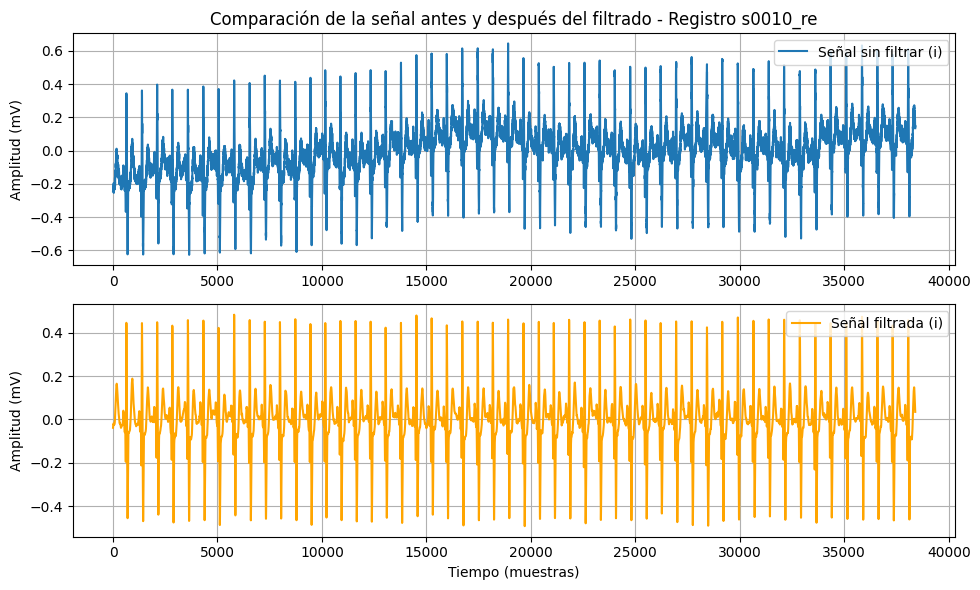

In [20]:
import matplotlib.pyplot as plt
# Selección del registro y canal a comparar

# Aplicar el filtro Butterworth a la señal
filtered_signal = stemi_records[0]

# Graficar señal antes y después del filtrado
plt.figure(figsize=(10, 6))

# Señal sin filtrar
plt.subplot(2, 1, 1)
plt.plot(raw_signal, label=f'Señal sin filtrar ({filtered_signal.sig_name[canal_a_comparar]})')
plt.title(f'Comparación de la señal antes y después del filtrado - Registro {filtered_signal.record_name}')
plt.ylabel('Amplitud (mV)')
plt.legend(loc='upper right')
plt.grid(True)

# Señal filtrada
plt.subplot(2, 1, 2)
plt.plot(filtered_signal.p_signal[:, canal_a_comparar], label=f'Señal filtrada ({filtered_signal.sig_name[canal_a_comparar]})', color='orange')
plt.ylabel('Amplitud (mV)')
plt.xlabel('Tiempo (muestras)')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

### Detección de latidos

In [21]:
import wfdb.processing

def calcular_vector_magnitud(record):
    # Calcular el vector magnitud de las señales ECG
    vector_magnitud = np.sqrt(np.sum(record.p_signal**2, axis=1))
    return vector_magnitud

def detectar_latidos(record, fs):
    # Calcular el vector magnitud
    vector_magnitud = calcular_vector_magnitud(record)
    
    # Detectar los picos R usando el algoritmo gqrs
    qrs_indices = wfdb.processing.gqrs_detect(sig=vector_magnitud, fs=fs)
    
    return qrs_indices

""" # Detectar latidos en los registros STEMI
for record in stemi_records:
    qrs_indices = detectar_latidos(record, 1000)
    # print(f"Latidos detectados en {record.record_name}: {len(qrs_indices)}")

# Detectar latidos en los registros HC
for record in HC_records:
    qrs_indices = detectar_latidos(record, 1000)
    # print(f"Latidos detectados en {record.record_name}: {len(qrs_indices)}") """

' # Detectar latidos en los registros STEMI\nfor record in stemi_records:\n    qrs_indices = detectar_latidos(record, 1000)\n    # print(f"Latidos detectados en {record.record_name}: {len(qrs_indices)}")\n\n# Detectar latidos en los registros HC\nfor record in HC_records:\n    qrs_indices = detectar_latidos(record, 1000)\n    # print(f"Latidos detectados en {record.record_name}: {len(qrs_indices)}") '

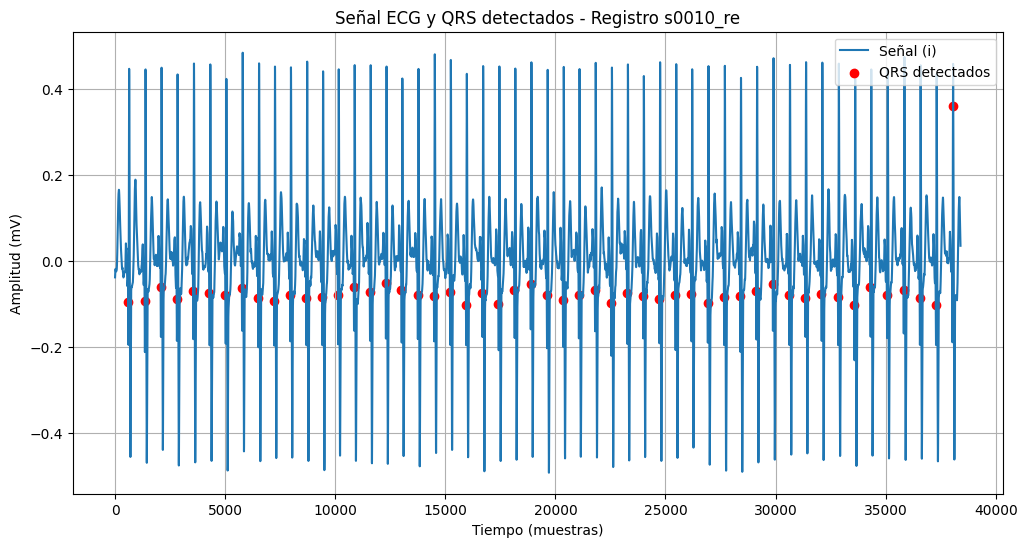

In [22]:
# Seleccionar un registro y canal para graficar
registro_a_graficar = stemi_records[0]  # Puedes cambiar el índice para seleccionar otro registro
canal_a_graficar = 0  # Índice del canal (ejemplo: 0 para el primer canal, i.e., Lead I)

# Calcular el vector magnitud y detectar los latidos
vector_magnitud = calcular_vector_magnitud(registro_a_graficar)
qrs_indices = detectar_latidos(registro_a_graficar, 1000)

# Graficar la señal y los índices QRS detectados
plt.figure(figsize=(12, 6))

# Graficar la señal del canal seleccionado
plt.plot(registro_a_graficar.p_signal[:, canal_a_graficar], label=f'Señal ({registro_a_graficar.sig_name[canal_a_graficar]})')

# Graficar los índices QRS detectados
plt.scatter(qrs_indices, registro_a_graficar.p_signal[qrs_indices, canal_a_graficar], color='red', marker='o', label='QRS detectados')

plt.title(f'Señal ECG y QRS detectados - Registro {registro_a_graficar.record_name}')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud (mV)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

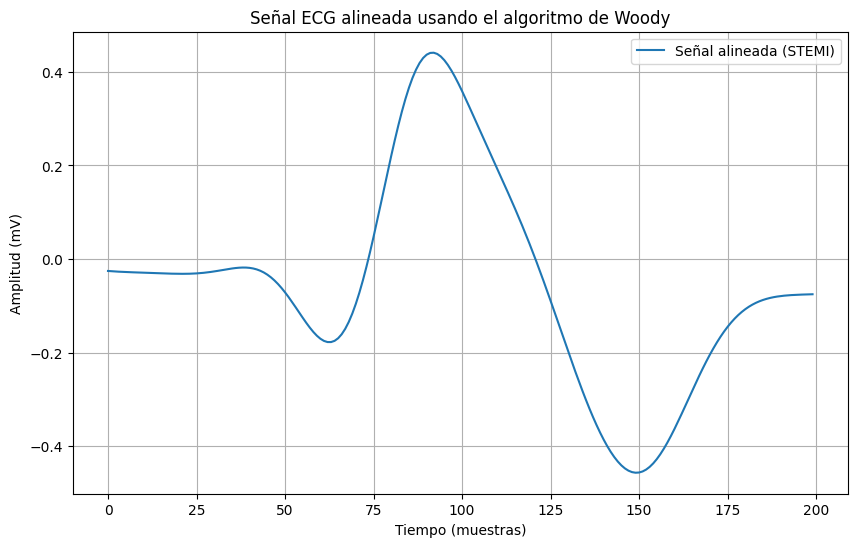

In [23]:
def woody_alignment(signals, qrs_indices):
    """
    Alinear latidos usando el algoritmo de Woody.
    
    Parameters:
    signals (np.ndarray): Señales ECG.
    qrs_indices (np.ndarray): Índices de los picos R detectados.
    window_size (int): Tamaño de la ventana alrededor del pico R para alinear.
    
    Returns:
    np.ndarray: Señales alineadas.
    """
    num_beats = len(qrs_indices)
    aligned_beats = []

    for idx in qrs_indices:
        start = idx - 50
        end = idx + 150

        if start >= 0 and end <= len(signals):
            beat = signals[start:end]
            aligned_beats.append(beat)

    aligned_beats = np.array(aligned_beats)
    mean_beat = np.mean(aligned_beats, axis=0)

    return mean_beat

# Alinear latidos en los registros STEMI
for record in stemi_records:
    qrs_indices = detectar_latidos(record, fs)
    record.aligned_signal = woody_alignment(record.p_signal[:, canal_a_comparar], qrs_indices)

# Alinear latidos en los registros HC
for record in HC_records:
    qrs_indices = detectar_latidos(record, fs)
    record.aligned_signal = woody_alignment(record.p_signal[:, canal_a_comparar], qrs_indices)

# Graficar una señal alineada como ejemplo
plt.figure(figsize=(10, 6))
plt.plot(stemi_records[0].aligned_signal, label='Señal alineada (STEMI)')
plt.title('Señal ECG alineada usando el algoritmo de Woody')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud (mV)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

/tmp/ipykernel_5441/1010403393.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


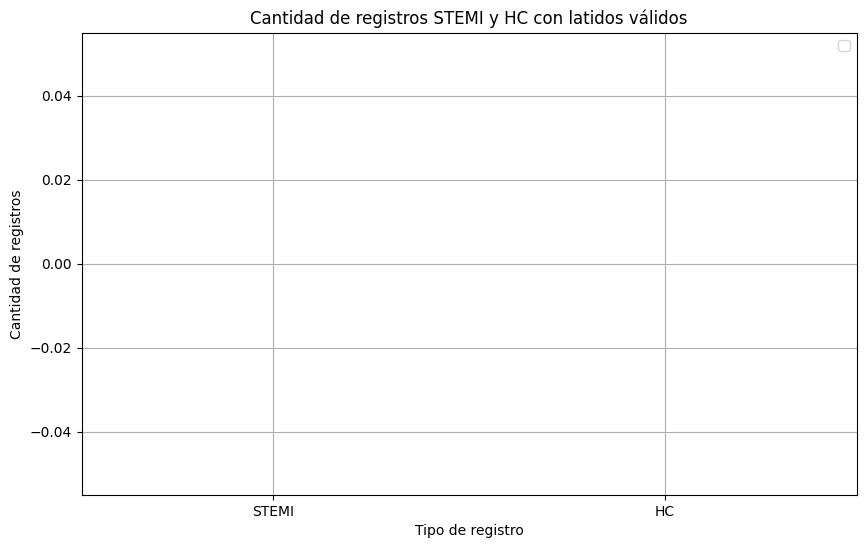

In [31]:
def crear_plantilla_qrs(records, qrs_indices):
    """
    Crear una plantilla QRS promedio a partir de los latidos detectados.
    
    Parameters:
    records (list): Lista de registros.
    qrs_indices (list): Lista de índices QRS detectados.
    window_size (int): Tamaño de la ventana alrededor del pico R para crear la plantilla.
    
    Returns:
    np.ndarray: Plantilla QRS promedio.
    """
    latidos = []

    for record in records:
        for idx in qrs_indices:
            start = idx - 50
            end = idx + 150

            if start >= 0 and end <= len(record.aligned_signal):
                latido = record.aligned_signal[start:end]  # Adjusted to handle 1D array
                latidos.append(latido)

    latidos = np.array(latidos)
    plantilla_qrs = np.mean(latidos, axis=0)

    return plantilla_qrs

def evaluar_calidad_latidos(record, qrs_indices, plantilla_qrs, umbral=0.9):
    """
    Evaluar la calidad de los latidos usando correlación cruzada con una plantilla QRS.
    
    Parameters:
    record (wfdb.io.record.Record): Registro a evaluar.
    qrs_indices (np.ndarray): Índices de los picos R detectados.
    plantilla_qrs (np.ndarray): Plantilla QRS promedio.
    umbral (float): Umbral de correlación para considerar un latido como válido.
    
    Returns:
    list: Lista de índices de latidos válidos.
    """
    latidos_validos = []

    for idx in qrs_indices:
        start = idx - len(plantilla_qrs) // 2
        end = idx + len(plantilla_qrs) // 2

        if start >= 0 and end <= len(record.aligned_signal):
            latido = record.aligned_signal[start:end]  # Adjusted to handle 1D array
            correlacion = np.corrcoef(latido, plantilla_qrs)[0, 1]

            if correlacion > umbral:
                latidos_validos.append(idx)

    return latidos_validos


qrs_indices = detectar_latidos(stemi_records[0], 1000)
# Crear plantilla QRS promedio
plantilla_qrs = crear_plantilla_qrs(stemi_records, qrs_indices)

# latidos validos:

latidos_validos_STEMI = []

# Evaluar la calidad de los latidos en los registros STEMI
for record in stemi_records:
    qrs_indices = detectar_latidos(record, fs)
    plantilla_qrs = crear_plantilla_qrs(stemi_records, qrs_indices)
    if plantilla_qrs.ndim > 1:
        plantilla_qrs = plantilla_qrs.flatten()  # Ensure plantilla_qrs is 1D
    if plantilla_qrs.size > 1:  # Ensure plantilla_qrs is not a scalar
        latidos_validos = evaluar_calidad_latidos(record, qrs_indices, plantilla_qrs)
        # print(f"Latidos válidos en {record.record_name}: {len(latidos_validos)}")
        if(len(latidos_validos) > 0):
            latidos_validos_STEMI.append(record)

latidos_validos_HC = []

# Evaluar calidad de latidos en los registros HC
for record in HC_records:
    qrs_indices = detectar_latidos(record, fs)
    plantilla_qrs = crear_plantilla_qrs(HC_records, qrs_indices)
    if plantilla_qrs.ndim > 1:
        plantilla_qrs = plantilla_qrs.flatten()  # Ensure plantilla_qrs is 1D
    if plantilla_qrs.size > 1:  # Ensure plantilla_qrs is not a scalar
        latidos_validos = evaluar_calidad_latidos(record, qrs_indices, plantilla_qrs)
        # print(f"Latidos válidos en {record.record_name}: {len(latidos_validos)}")
        if(len(latidos_validos) > 0):
            latidos_validos_HC.append(record)

# Histograma de cantidad de registros STEMI de la viable stemi_records y HC_records
plt.figure(figsize=(10, 6))
bars = plt.bar(['STEMI', 'HC'], [len(latidos_validos_STEMI), len(latidos_validos_HC)], color=['blue', 'green'])
plt.title('Cantidad de registros STEMI y HC con latidos válidos')
plt.xlabel('Tipo de registro')
plt.ylabel('Cantidad de registros')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

